# ITSM 601 Semester Project
## Austin Animal Shelter Data
### Predicts Adopted/Not Adopted

Travis Lemon and John Bonfardeci
Class of 2018

#### What this notebook does:
* Create randomized K cross-validation (CV) groups
* For-each CV:
    * Split randomized data into (k-1)/k training data and 1/k testing
    * Run LDA K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
    * Run Logistic Regression K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
Directions in Jupyter Notebook: Select `Cell -> Run All`. 
Look for printed output and ROC plots at bottom of notebook.

In [1]:
# Change These Parameters

# relative file path; can place in same working directory as notebook
FILE_PATH = 'animal_shelter_train.csv'

# name of target column
TARGET_NAME = 'Adopted'

# Name of Key/ID column
KEY_NAME='AnimalID'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
TARGET_VALUE = 1 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
LDA_SOLVER = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
LDA_SHRINKAGE = 'auto'

# number of cross-validation groups to run
NUM_CV = 5

output_data_to_excel = False
save_figs = True
output_dir = ''

All of the links below proved helpful in the researh for writing this notebook.
* http://sebastianraschka.com/Articles/2014_python_lda.html#introduction
* http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
* https://en.wikipedia.org/wiki/Sensitivity_and_specificity
* https://en.wikipedia.org/wiki/Youden%27s_J_statistic
* http://stats.stackexchange.com/questions/29719/how-to-determine-best-cutoff-point-and-its-confidence-interval-using-roc-curve-i
* https://sasshowcase.wordpress.com/category/sas-macro/
* http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
* https://www.medcalc.org/manual/roc-curves.php
* http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf
* http://www.umich.edu/~ners580/ners-bioe_481/lectures/pdfs/1978-10-semNucMed_Metz-basicROC.pdf
* http://scikit-learn.org/stable/modules/cross_validation.html
* http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* http://gim.unmc.edu/dxtests/roc2.htm
* https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
* http://scikit-learn.org/stable/modules/feature_selection.html

In [2]:
#Import Dependent Libraries
# DON'T change below this line unless you know what your're doing.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import math
import pandas as pd
import numpy as np
from scipy import interp
from itertools import cycle
from copy import copy

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE, SelectFromModel
from IPython.display import display
import re
import statsmodels.api as sm
import os
#from sklearn.feature_selection import VarianceThreshold
#from sklearn import svm 
#from sklearn.feature_selection import f_regression 
#from sklearn.feature_selection import SelectFpr 
#from sklearn.feature_selection import SelectKBest 
#from sklearn.feature_selection import SelectPercentile 
#from sklearn.feature_selection import SelectFromModel
#from sklearn.pipeline import make_pipeline
#from sklearn.decomposition import PCA, FactorAnalysis


C:\Users\bonfardeci-j\Anaconda2\envs\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Define global vars
X = None # Matrix of variables
y = None # Dependent variable list
keys = None # Key/ID values
columns = None # Names of variables
df = None # Pandas dataframe to store our model data.

# Import Data
def import_data(file_path, randomize=False):
    """
    Import a CSV file to a Pandas dataframe.
    @param file_path <string>
    @randomize <boolean> default=False
    @return Pandas Dataframe
    """
    if not os.path.exists(file_path):
        print('Invalid file path!')
        return None
        
    df = pd.read_csv(file_path) # returns new Pandas DataFrame 

    # randomize rows (http://quabr.com/29576430/shuffle-dataframe-rows)
    if randomize:
        df = df.iloc[np.random.permutation(len(df))]
  
    return df

def get_data_model(file_path, target_name, target_value, key_name, convert_to_indicators=False):
    """
    Get the data model.
    @param target_name <string>
    @param key_name <string>
    @param convert_to_indicators <boolean> default=False
    @return [y, X, df, columns] <list>
    """
    df = import_data(file_path, True)
    df = df.dropna()
    y = pd.Series( map(lambda x: 1 if x == target_value else 0, df[target_name]) ).as_matrix()
    keys = df[key_name]
    df = df.drop(target_name, 1).drop(key_name, 1)
    
    if convert_to_indicators:
        df = pd.get_dummies(df)
        # Clean col names removing special characters
        df.columns = map(lambda c: re.sub('\W+','', c), df.columns)
    
    print("Loaded dataset successfully.")
    display(df.describe())
    X = df.as_matrix()    
    return [y, X, df, df.columns]
  
y, X, df, columns = get_data_model(FILE_PATH, target_name=TARGET_NAME, target_value=TARGET_VALUE, key_name=KEY_NAME)

Loaded dataset successfully.


,Cat,IntactFemale,IntactMale,NeuteredMale,SpayedFemale,AgeRange_0,AgeRange_1_4,AgeRange_10_15,AgeRange_15_20,AgeRange_5_9,...,Calico,OrangeTabby,Other,Red,Tan,Tortie,Tricolor,Yellow,MixBreed,PitBull
count,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,...,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000
mean,0.416551,0.131355,0.131879,0.365857,0.329979,0.593999,0.248270,0.039134,0.005724,0.112874,...,0.019342,0.050619,0.372517,0.024992,0.066968,0.019829,0.028134,0.008530,0.834225,0.089491
std,0.492996,0.337795,0.338366,0.481679,0.470214,0.491094,0.432017,0.193916,0.075442,0.316444,...,0.137728,0.219223,0.483484,0.156102,0.249972,0.139414,0.165359,0.091965,0.371885,0.285456
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
def get_var_estimates(target_name, y, X, columns):
    """
    Show OLS parameter estimates for the model.
    Ref: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
    http://statsmodels.sourceforge.net/devel/examples/generated/example_ols.html
    @param target_name <string>
    @param y <list>
    @param X <Pandas Dataframe>
    @param columns <list>
    @returns void
    """
    model = sm.OLS(y, X)
    results = model.fit()

    #[yname, xname, title, alpha]
    display(results.summary(target_name, columns, 'PValues', 0.05))
    
get_var_estimates(target_name=TARGET_NAME, y=y, X=X, columns=[c for c in columns])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   PValues                                    
==============================================================================
Dep. Variable:                Adopted   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     467.6
Date:                Sat, 14 Apr 2018   Prob (F-statistic):               0.00
Time:                        11:42:49   Log-Likelihood:                -13871.
No. Observations:               26729   AIC:                         2.780e+04
Df Residuals:                   26702   BIC:                         2.802e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Cat                0.0343      0.007      4.758      0.000       0.020       0.048
IntactFemale       0.1122      0.014      7.854      0.000       0.084       0.140
IntactMale         0.1007      0.014      7.065      0.000       0.073       0.129
NeuteredMale       0.6540      0.013     48.661      0.000       0.628       0.680
SpayedFemale       0.7042      0.014     52.131      0.000       0.678       0.731
AgeRange_0         0.0689      0.012      5.882      0.000       0.046       0.092
AgeRange_1_4      -0.1472      0.012    -11.964      0.000      -0.171      -0.123
AgeRange_10_15    -0.2775      0.017    -16.736      0.000      -0.310      -0.245
AgeRange_15_20    -0.3549      0.033    -10.647      0.000      -0.420      -0.290
AgeRange_5_9      -0.2303      0.013    -17.135      0.000      -0.257      -0.204
Black_Brown       -0.0386      0.015     -2.595      0.009      -0.068      -0.009
Black_Tan         -0.0580      0.014     -4.075      0.000      -0.086      -0.030
Black_White       -0.0586      0.008     -7.300      0.000      -0.074      -0.043
Blue              -0.0479      0.019     -2.499      0.012      -0.086      -0.010
Blue Tabby        -0.0245      0.016     -1.528      0.126      -0.056       0.007
Blue_White        -0.0290      0.015     -1.969      0.049      -0.058      -0.000
Brown             -0.0616      0.009     -6.552      0.000      -0.080      -0.043
Brown_White       -0.0457      0.011     -4.009      0.000      -0.068      -0.023
Calico            -0.0659      0.018     -3.571      0.000      -0.102      -0.030
OrangeTabby       -0.0459      0.012     -3.686      0.000      -0.070      -0.021
Other             -0.0558      0.006     -9.227      0.000      -0.068      -0.044
Red               -0.0807      0.016     -5.103      0.000      -0.112      -0.050
Tan               -0.0568      0.010     -5.433      0.000      -0.077      -0.036
Tortie            -0.0753      0.018     -4.120      0.000      -0.111      -0.039
Tricolor          -0.0562      0.015     -3.745      0.000      -0.086      -0.027
Yellow            -0.1406      0.026     -5.381      0.000      -0.192      -0.089
MixBreed          -0.0164      0.007     -2.310      0.021      -0.030      -0.002
PitBull           -0.0834      0.010     -8.774      0.000      -0.102      -0.065
==============================================================================
Omnibus:                     5234.034   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1068.976
Skew:                          -0.071   Prob(JB):                    7.50e-233
Kurtosis:                       2.031   Cond. No.                     1.31e+15
==============================================================================

Warnings:
[1] Standard Errors assum

In [5]:
# Lasso feature selection
def get_lasso_selection(X, y, columns):
    """
    Select significant variables according to Lasso.
    @param X <Pandas Dataframe>
    @param y <list>
    @columns <list>
    @returns <list>
    """
    clf = LassoCV()
    sfm = SelectFromModel(clf)
    sfm.fit(X, y)
    features = sfm.transform(X).shape[1]
    feature_indices = sfm.get_support()
    significant_features = []
    for c, b in zip(columns, feature_indices):
        if b:
            significant_features.append(c)
            
    return significant_features
    
significant_features = get_lasso_selection(X=X, y=y, columns=columns)
print('Selected significant variables are:\r\n', ', '.join(significant_features))

def remove_insignificant_vars(sig_var_list, df):
    drop = []
    cols = df.columns.tolist()
    #print(cols)
    for v in cols:
        if not v in sig_var_list:
            drop.append(v)
            df = df.drop(str(v), 1)
            
       
    print('\r\nDropped insignificant vars: ', ', '.join(drop))
    display(df.describe())
    return df
    
df = remove_insignificant_vars(significant_features, df.copy())
X = df.as_matrix() 
columns = df.columns.tolist()

Selected significant variables are:
 Cat, IntactFemale, IntactMale, NeuteredMale, SpayedFemale, AgeRange_0, AgeRange_1_4, AgeRange_10_15, AgeRange_15_20, Black_Brown, Black_White, Blue Tabby, Blue_White, Brown, Brown_White, OrangeTabby, Red, Tortie, Yellow, MixBreed, PitBull

Dropped insignificant vars:  AgeRange_5_9, Black_Tan, Blue, Calico, Other, Tan, Tricolor


,Cat,IntactFemale,IntactMale,NeuteredMale,SpayedFemale,AgeRange_0,AgeRange_1_4,AgeRange_10_15,AgeRange_15_20,Black_Brown,...,Blue Tabby,Blue_White,Brown,Brown_White,OrangeTabby,Red,Tortie,Yellow,MixBreed,PitBull
count,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,...,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000
mean,0.416551,0.131355,0.131879,0.365857,0.329979,0.593999,0.248270,0.039134,0.005724,0.028770,...,0.026039,0.031165,0.090202,0.054360,0.050619,0.024992,0.019829,0.008530,0.834225,0.089491
std,0.492996,0.337795,0.338366,0.481679,0.470214,0.491094,0.432017,0.193916,0.075442,0.167163,...,0.159255,0.173766,0.286476,0.226732,0.219223,0.156102,0.139414,0.091965,0.371885,0.285456
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
def get_balanced_accuracy(tpr, fpr):
    """
    Get Balanced Accuracy - an average of the true positive rate and false positive rate.
    Dr. Alan Dabney
    
    @param tpr: float (True Positive Rate - the Sensitivity)
    @param fpr: float (False Positive Rate - the 1-Specificity)
    @returns float
    """
    return (tpr + (1-fpr)) / 2

In [7]:
# Confusion Matrix
def get_confusion_matrix(cutoff, actual, prob):
    """
    Return a confusion matrix with the optimal threshold/cutoff for probability of Y.
    
    TN | FP
    -------
    FN | TP
    
    For example: 
    
       n=165   | Predicted NO | Predicted YES
    ------------------------------------------
    Actual NO  |       50     |      10       |
    ------------------------------------------
    Actual YES |       5      |      100      |
    ------------------------------------------
    
    The diagonal elements represent the number of points for which the predicted label is equal to the true label,
    while off-diagonal elements are those that are mislabeled by the classifier.
    The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
    """
    pred = []
    for (x, y) in prob:
        pred.append(1 if y > cutoff else 0)

    return confusion_matrix(actual, pred)


def get_tpr_fpr(cm):
    """
    Sensitivity: TruePos / (True Pos + False Neg) 
    Specificity: True Neg / (False Pos + True Neg)
    TN | FP
    -------
    FN | TP
    """
    
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])
    
    tpr = tp / (tp + fn)
    fpr = 1-(tn / (fp + tn))
    
    return [tpr, fpr]   

In [8]:
def get_best_cutoff(actual, prob):  
    """
    Get the best cutoff according to Balanced Accuracy
    'Brute-force' technique - try all cutoffs from 0.01 to 0.99 in increments of 0.01
    
    @param actual list<float>
    @param prob list<tuple<float, float>>
    @returns list<float>
    """
    best_tpr = 0.0; best_fpr = 0.0; best_cutoff = 0.0; best_ba = 0.0; 
    cutoff = 0.0
    while cutoff < 1.0:
        cm = get_confusion_matrix(cutoff=cutoff, actual=actual, prob=prob)
        _tpr, _fpr = get_tpr_fpr(cm)
        
        if(_tpr < 1.0):    
            ba = get_balanced_accuracy(tpr=_tpr, fpr=_fpr)
        
            if(ba > best_ba):
                best_ba = ba
                best_cutoff = cutoff
                best_tpr = _tpr
                best_fpr = _fpr
        
        cutoff += 0.01
        
    return [best_tpr, best_fpr, best_cutoff, best_ba]

In [9]:
def get_accuracy(C):
    """
    Get the accuracy rate of a confusion matrix
    TN | FP
    -------
    FN | TP
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN
    accuracy = (tp+tn+0.)/N
    return accuracy


def show_confusion_matrix(C, class_labels=['0','1'], figsize=(6,6), fontsize=12, filename='roc-curve'):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    https://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted', fontsize=fontsize)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('Actual', fontsize=fontsize, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.4f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.4f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    if save_figs:
        filename = '%s%s.png' % (output_dir, filename)
        plt.savefig(filename)
        print('Confusion matrix image was saved to: %s' % (filename))
        
    plt.tight_layout()
    plt.show()

In [10]:
def show_roc(kfolds, mean_tpr, mean_fpr, title, lw=2, filename='roc'):
    """
    Display and save ROC curve
    """
    plt.figure(figsize=(12,12))
    colors = cycle(['cyan', 'red', 'seagreen', 'darkorange', 'blue'])
    
    # Plot the ROC Curve for this CV group
    i=0
    for (k, color) in zip(kfolds, colors):
        tpr, fpr = k[0], k[1]
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
        i += 1
    
    # Plot the ROC Curve for logistic regression
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

    mean_tpr /= len(kfolds)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive (1-Specificity)')
    plt.ylabel('True Positive (Sensitivity)')
    plt.title(title)
    plt.legend(loc="lower right")
    
    if save_figs:
        filename = '%s%s.png' % (output_dir, filename)
        plt.savefig(filename)
        print('ROC image was saved to: %s' % (filename))
        
    plt.show()

In [11]:
#Output to Excel
def output_excel(filename, prob, x, y, predicted, sheetname='Sheet1'):
    """
    Output data k-fold data to Excel
    """
    prob_cols = [target_name, 'Prob[0]', 'Prob[1]', 'Predicted']
    col_names = np.asarray(feature_names)    
    col_names = np.append( np.asarray(col_names), np.asarray(prob_cols))
    
    data = []
    
    i = 0
    for xrow, yrow, prob, pred in zip(x, y, prob, predicted):
        a = []
        for col in xrow:
            a.append(col)

        a.append(yrow)
        a.append(prob[0])
        a.append(prob[1])
        a.append(pred)
        data.append(a)
        i+=1

    df = pd.DataFrame(data=data, columns=col_names)
        
    filename = '%s%s.csv'%(output_dir, filename)
    #writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    #df.to_excel(writer, sheet_name=sheetname)
    #writer.save()
    df.to_csv(filename, sep=',', encoding='utf-8')
    print('Excel file was saved to: %s' % (filename))
    

def output_roc(filename, sheetname, tpr, fpr, cutoffs):
    """
    Output ROC data to Excel
    """
    data = []
    for (t, f, c) in zip(tpr, fpr, cutoffs):
        data.append([t, f, c])
        
    df = pd.DataFrame(data=data, columns=['Sensitivity', '1-Specificity', 'Cutoff'])
       
    filename = '%s%s.csv'%(output_dir, filename) 
    #writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    #df.to_excel(writer, sheet_name=sheetname)
    #writer.save()
    df.to_csv(filename, sep=',', encoding='utf-8')
    print('ROC image was saved to %s'%(filename))

            
def output_cms(filename, data, sheetname='Sheet1'):
    """
    Output Cutoffs, TPR, FPR, Confusion, ... to Excel 
    """
    
    cols = ['Method', 'FoldNum', 'Cutoff', 'Sensitivity', '1-Specificity', 
            'TrueNeg', 'FalsPos', 'FalseNeg', 'TruePos', 'Accuracy', 'AUC', 'Balanced Accuracy']

    df = pd.DataFrame(data=data, columns=cols)
    df.sort_values(by=['FoldNum', 'Cutoff'])
        
    filename = '%s%s.csv'%(output_dir, filename)
    #writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    #df.to_excel(writer, sheet_name=sheetname)
    #writer.save()
    df.to_csv(filename, sep=',', encoding='utf-8')
    print('Excel file was saved to: %s' % (filename))
    
    
def get_cm_row(method, foldnum, cutoff, actual, prob):
    """
    Create new row for output: Cutofs, TPR, FPR, Confusion, ... to Excel 

    TN | FP
    -------
    FN | TP
    """
    cm = get_confusion_matrix(cutoff, actual, prob)
    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1]
    tpr, fpr = get_tpr_fpr(cm)
    accuracy = get_accuracy(cm)
    _fpr, _tpr, cutoffs = roc_curve(actual, prob[:, 1])
    _auc = auc(_fpr, _tpr)
    ba = get_balanced_accuracy(tpr, fpr)
    
    return(method, foldnum, cutoff, tpr, fpr, tn, fp, fn, tp, accuracy, _auc, ba)

0.40289573122825395


C:\Users\bonfardeci-j\Anaconda2\envs\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Fold 1, TPR: 0.75859, FPR: 0.23622, Cutoff: 0.33000, BA: 0.76119
Fold 2, TPR: 0.83983, FPR: 0.33897, Cutoff: 0.28000, BA: 0.75043
Fold 3, TPR: 0.86351, FPR: 0.33897, Cutoff: 0.28000, BA: 0.76227
Fold 4, TPR: 0.86212, FPR: 0.36090, Cutoff: 0.28000, BA: 0.75061
Fold 5, TPR: 0.84858, FPR: 0.34868, Cutoff: 0.27000, BA: 0.74995
Means:  TPR: 0.83453, FPR: 0.32475, Cutoff: 0.28800, BA: 0.75489
ROC image was saved to: lda-roc.png


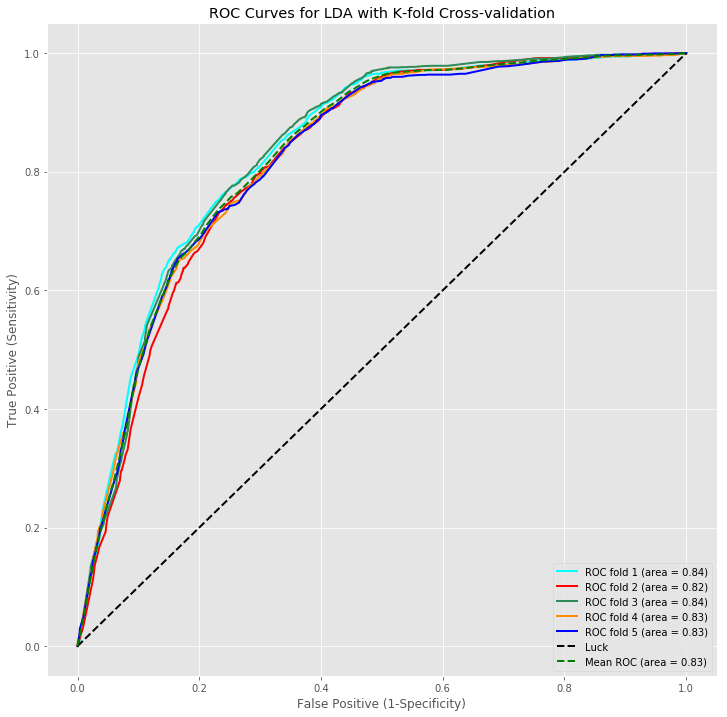

Confusion matrix image was saved to: lda-best-tp-cm.png


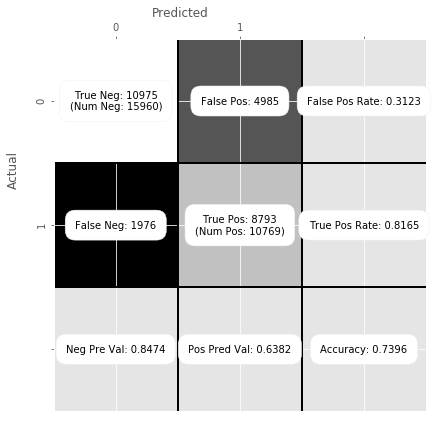

In [12]:
# Run LDA with cross-validation and plot ROC curves
def run_lda():
    rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV, shuffle=True, random_state=rand)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = []
    cm_folds = []
    lda_actual = []
    lda_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0
    best_mean_ba = 0.0

    # [0.68960044  0.31039956]
    prior = len([n for n in y if n == 1])/len(X) # = 0.31039111820622595
    print(prior)

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # TODO - add feature selection per CV
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train LDA on training dataset
        lda = LinearDiscriminantAnalysis(priors=[0.68960044, 0.31039956], solver=LDA_SOLVER,  
                                         shrinkage=LDA_SHRINKAGE, store_covariance=True).fit(train_X, train_y)

        # test LDA on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = lda.predict_proba(test_X)
        #z_labels = lda.predict(test_X)
        # print(z_labels)

        """
        s_fpr = SelectFpr()   
        pvalue_data = []
        for (col, val) in zip(df.columns, s_fpr.fit(train_X, train_y).pvalues_):
            pvalue_data.append( (col, float(val)) )

        df_pvalues = pd.DataFrame(data=pvalue_data, columns=['X', 'pvalue'])\
            .sort_values(by='pvalue', ascending=True)
        display( df_pvalues )
        """

        # display explained variance ratio
        #variance = pd.DataFrame(data=lda.explained_variance_ratio_)
        #display(variance)

        # display covariance matrix
        #cov = pd.DataFrame(data=lda.covariance_)
        #display(cov)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = lda.predict(test_X)
        train_predicted = lda.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3

        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        if output_data_to_excel:
            output_excel('lda-fold-%d-test' % (i+1), prob, test_X, test_actual, predicted, 'TestSet%d' % (i+1))
            output_excel('lda-fold-%d-train' % (i+1), 
                         lda.predict_proba(train_X), train_X, train_y, train_predicted, 'TrainSet%d' % (i+1))
        # /if...

        lda_actual.extend(test_actual)
        lda_prob.extend(prob)

        roc_kfolds.append([tpr, fpr])

        #output_cutoffs(i, tpr, fpr, thresholds, prob)

        best_tpr, best_fpr, best_cutoff, best_ba = get_best_cutoff(actual=test_actual, prob=prob)
        print('Fold %d, TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f' % (i+1, best_tpr, best_fpr, best_cutoff, best_ba))
        best_mean_cutoff += best_cutoff
        best_mean_tpr += best_tpr
        best_mean_fpr += best_fpr
        best_mean_ba += best_ba

        i += 1
        #/for (train, test)...

    best_mean_cutoff /= float(NUM_CV)
    print('Means:  TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f'%(best_mean_tpr/float(NUM_CV),
                                                        best_mean_fpr/float(NUM_CV), 
                                                        best_mean_cutoff, 
                                                        best_mean_ba/float(NUM_CV)))

    show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for LDA with K-fold Cross-validation', 2, 'lda-roc')

    if output_data_to_excel:
        output_cms('lda-cms', cm_folds, 'LDA_Test_Folds') # output to excel

    best_tp = get_confusion_matrix(best_mean_cutoff, lda_actual, lda_prob)
    show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'lda-best-tp-cm')
    
    
run_lda()

Fold 1, TPR: 0.77391, FPR: 0.25282, Cutoff: 0.43000, BA: 0.76054
Fold 2, TPR: 0.83937, FPR: 0.33302, Cutoff: 0.39000, BA: 0.75317
Fold 3, TPR: 0.86119, FPR: 0.33553, Cutoff: 0.38000, BA: 0.76283
Fold 4, TPR: 0.85005, FPR: 0.34743, Cutoff: 0.39000, BA: 0.75131
Fold 5, TPR: 0.84487, FPR: 0.34461, Cutoff: 0.38000, BA: 0.75013
Means:  TPR: 0.83388, FPR: 0.32268, Cutoff: 0.39400, BA: 0.75560
ROC image was saved to: logit-roc.png


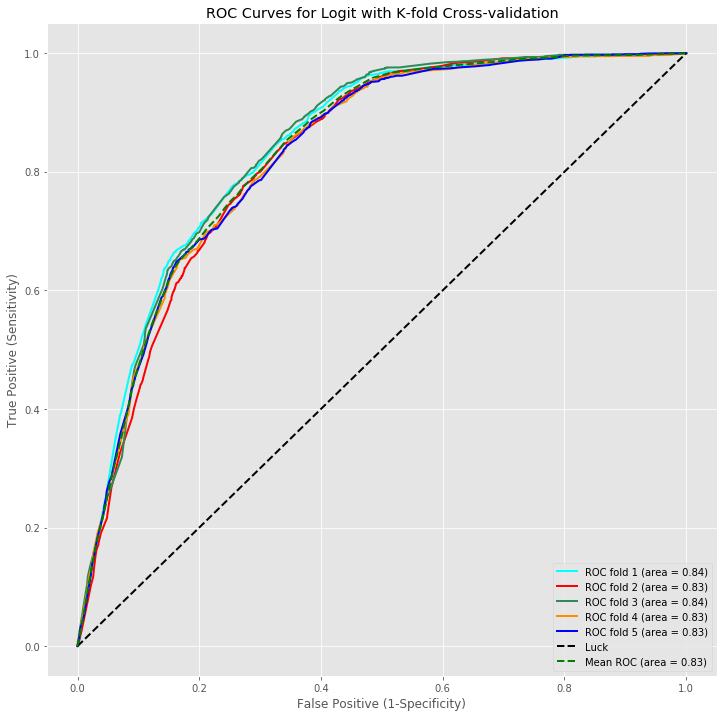

Confusion matrix image was saved to: logit-best-tp-cm.png


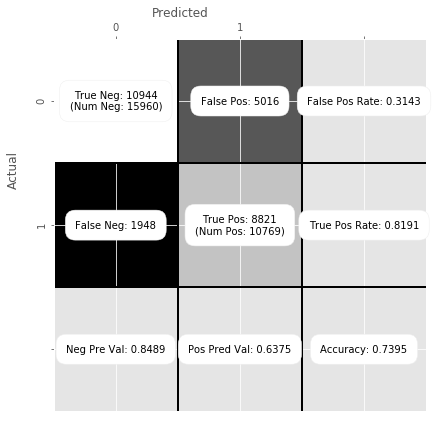

In [13]:
# Run logistic Regression with cross-validation and plot ROC curves
# Logit can use categorical variaables. Append to cols and get new data set
def run_logit():
    rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV, shuffle=True, random_state=rand)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = []
    cm_folds = []
    logit_actual = []
    logit_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0
    best_mean_ba = 0.0

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train Logit on training dataset
        logit = LogisticRegression()
        logit.fit(train_X, train_y)

        # test Logit on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = logit.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = logit.predict(test_X)
        train_predicted = logit.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3

        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        if output_data_to_excel:
            output_excel('logit-fold-%d-test' % (i+1), prob, test_X, test_actual, predicted, 'TestSet%d' % (i+1))
            output_excel('logit-fold-%d-train' % (i+1), 
                         logit.predict_proba(train_X), train_X, train_y, train_predicted, 'TrainSet%d' % (i+1))
        # /if...

        logit_actual.extend(test_actual)
        logit_prob.extend(prob)

        roc_kfolds.append([tpr, fpr])

        #output_cutoffs(i, tpr, fpr, thresholds, prob)

        best_tpr, best_fpr, best_cutoff, best_ba = get_best_cutoff(actual=test_actual, prob=prob)
        print('Fold %d, TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f' % (i+1, best_tpr, best_fpr, best_cutoff, best_ba))
        best_mean_cutoff += best_cutoff
        best_mean_tpr += best_tpr
        best_mean_fpr += best_fpr
        best_mean_ba += best_ba

        i += 1
    #/for (train, test)...

    best_mean_cutoff /= float(NUM_CV)

    print('Means:  TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f'%(best_mean_tpr/float(NUM_CV),
                                                        best_mean_fpr/float(NUM_CV), 
                                                        best_mean_cutoff, 
                                                        best_mean_ba/float(NUM_CV)))

    show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logit with K-fold Cross-validation', 2, 'logit-roc')

    if output_data_to_excel:
        output_cms('logit-cms', cm_folds, 'Logit_Test_Folds') # output to excel

    best_tp = get_confusion_matrix(best_mean_cutoff, logit_actual, logit_prob)
    show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'logit-best-tp-cm')
    
run_logit()